In [1]:
# Install required libraries
!pip install tensorflow matplotlib pandas numpy nltk

In [2]:
# Install required libraries if not already installed
!pip install wget

# Import necessary library
import os

# Define the dataset URL from Dropbox
url = "https://www.dropbox.com/sh/q4dehgdtbo0b6vt/AABFoMwAxqEQWQnl_xQYY2fsa?dl=1"  # Note: "?dl=1" forces download

# Download the dataset ZIP file
!wget -O flickr8k_dataset.zip "{url}"

# Create a directory to extract the dataset
os.makedirs("Flickr8k", exist_ok=True)

# Extract the ZIP file
!unzip -q flickr8k_dataset.zip -d Flickr8k

# Check the extracted contents
!ls -R Flickr8k


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3f71821831afbb275cf483f0ee9095a51a6c0f655215928f63968acb93f7f605
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-25 19:12:00--  https://www.dropbox.com/sh/q4dehgdtbo0b6vt/AABFoMwAxqEQWQnl_xQYY2fsa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1&dl=1 [following]
--2025-01-25 19:12:00--  https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from keras.preprocessing import image, sequence
from keras.applications import InceptionV3
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, add
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu


In [4]:
# Step 1: Dataset Setup /content/Flickr8k
images_path = '/content/Flickr8k/Flicker8k_Dataset'
captions_path = '/content/Flickr8k/Flickr8k_text/Flickr8k.token.txt'
train_path = '/content/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '/content/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
annotations_path = '/content/Flickr8k/Flickr8k_text/ExpertAnnotations.txt'

In [5]:
# Step 2: Preprocessing Captions
def load_captions(captions_file):
    """Load captions into a dictionary."""
    with open(captions_file, 'r') as file:
        lines = file.readlines()

    captions_dict = {}
    for line in lines:
        tokens = line.strip().split('#')
        image_id = tokens[0]
        caption = tokens[1].split('\t')[1]
        if image_id not in captions_dict:
            captions_dict[image_id] = []
        captions_dict[image_id].append(caption)

    return captions_dict

captions_dict = load_captions(captions_path)

In [6]:
# Step 3: Filter Captions Based on Expert Annotations
def filter_expert_annotations(annotations_file, captions_dict):
    """Filter captions based on expert annotations."""
    with open(annotations_file, 'r') as file:
        lines = file.readlines()

    filtered_captions = {}
    for line in lines:
        tokens = line.strip().split('\t')
        image_id, caption_id, score = tokens[0], tokens[1], int(tokens[2])
        if score >= 3:  # Filter captions with a score of 3 or higher
            caption = captions_dict[image_id][int(caption_id.split('#')[1])]
            if image_id not in filtered_captions:
                filtered_captions[image_id] = []
            filtered_captions[image_id].append(caption)

    return filtered_captions

filtered_captions = filter_expert_annotations(annotations_path, captions_dict)

In [7]:
# Step 4: Preprocess Images
def preprocess_image(image_path):
    """Preprocess an image for feature extraction."""
    img = image.load_img(image_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

In [8]:
# Feature extraction using InceptionV3
base_model = InceptionV3(weights='imagenet')
model_incep = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
from tqdm import tqdm  # For progress bar

image_features = {}
batch_size = 32  # Define batch size
image_ids = os.listdir(images_path)
batches = [image_ids[i:i+batch_size] for i in range(0, len(image_ids), batch_size)]

for batch in tqdm(batches, desc="Extracting Features"):
    batch_images = []
    for img_id in batch:
        image_path = os.path.join(images_path, img_id)
        batch_images.append(preprocess_image(image_path))

    batch_images = np.vstack(batch_images)  # Stack all images in the batch
    batch_features = model_incep.predict(batch_images)

    for img_id, feature in zip(batch, batch_features):
        image_features[img_id] = feature.flatten()


Extracting Features:   0%|          | 0/253 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Extracting Features:   0%|          | 1/253 [00:20<1:27:12, 20.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:   1%|          | 2/253 [00:21<36:49,  8.80s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:   1%|          | 3/253 [00:21<20:45,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   2%|▏         | 4/253 [00:22<13:09,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:   2%|▏         | 5/253 [00:22<08:54,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:   2%|▏         | 6/253 [00:22<06:22,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting Features:   3%|▎         | 7/253 [00:23<04:50,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   3%|▎         | 8/253 [00:23<04:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   4%|▎         | 9/253 [00:24<03:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:   4%|▍         | 10/253 [00:24<03:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:   4%|▍         | 11/253 [00:25<02:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:   5%|▍         | 12/253 [00:25<02:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   5%|▌         | 13/253 [00:26<02:19,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   6%|▌         | 14/253 [00:26<02:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   6%|▌         | 15/253 [00:27<01:55,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:   6%|▋         | 16/253 [00:27<01:47,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   7%|▋         | 17/253 [00:27<01:42,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   7%|▋         | 18/253 [00:28<01:37,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   8%|▊         | 19/253 [00:28<01:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   8%|▊         | 20/253 [00:29<01:32,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:   8%|▊         | 21/253 [00:29<01:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   9%|▊         | 22/253 [00:29<01:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:   9%|▉         | 23/253 [00:30<01:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   9%|▉         | 24/253 [00:30<01:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  10%|▉         | 25/253 [00:30<01:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  10%|█         | 26/253 [00:31<01:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  11%|█         | 27/253 [00:31<01:27,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  11%|█         | 28/253 [00:32<01:27,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  11%|█▏        | 29/253 [00:32<01:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  12%|█▏        | 30/253 [00:32<01:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  12%|█▏        | 31/253 [00:33<01:26,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  13%|█▎        | 32/253 [00:33<01:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  13%|█▎        | 33/253 [00:34<01:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  13%|█▎        | 34/253 [00:34<01:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  14%|█▍        | 35/253 [00:34<01:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  14%|█▍        | 36/253 [00:35<01:24,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  15%|█▍        | 37/253 [00:35<01:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  15%|█▌        | 38/253 [00:36<01:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  15%|█▌        | 39/253 [00:36<01:41,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:  16%|█▌        | 40/253 [00:37<01:43,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting Features:  16%|█▌        | 41/253 [00:37<01:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting Features:  17%|█▋        | 42/253 [00:38<01:44,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  17%|█▋        | 43/253 [00:38<01:46,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  17%|█▋        | 44/253 [00:39<01:40,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  18%|█▊        | 45/253 [00:39<01:35,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  18%|█▊        | 46/253 [00:39<01:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  19%|█▊        | 47/253 [00:40<01:26,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  19%|█▉        | 48/253 [00:40<01:24,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  19%|█▉        | 49/253 [00:41<01:22,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  20%|█▉        | 50/253 [00:41<01:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  20%|██        | 51/253 [00:41<01:19,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  21%|██        | 52/253 [00:42<01:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  21%|██        | 53/253 [00:42<01:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  21%|██▏       | 54/253 [00:43<01:16,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  22%|██▏       | 55/253 [00:43<01:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  22%|██▏       | 56/253 [00:43<01:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  23%|██▎       | 57/253 [00:44<01:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  23%|██▎       | 58/253 [00:44<01:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  23%|██▎       | 59/253 [00:44<01:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  24%|██▎       | 60/253 [00:45<01:14,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  24%|██▍       | 61/253 [00:45<01:14,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  25%|██▍       | 62/253 [00:46<01:13,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  25%|██▍       | 63/253 [00:46<01:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  25%|██▌       | 64/253 [00:46<01:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  26%|██▌       | 65/253 [00:47<01:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  26%|██▌       | 66/253 [00:47<01:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  26%|██▋       | 67/253 [00:48<01:14,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  27%|██▋       | 68/253 [00:48<01:13,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  27%|██▋       | 69/253 [00:49<01:22,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:  28%|██▊       | 70/253 [00:49<01:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:  28%|██▊       | 71/253 [00:50<01:28,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting Features:  28%|██▊       | 72/253 [00:50<01:29,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  29%|██▉       | 73/253 [00:51<01:29,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  29%|██▉       | 74/253 [00:51<01:30,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  30%|██▉       | 75/253 [00:52<01:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  30%|███       | 76/253 [00:52<01:23,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  30%|███       | 77/253 [00:52<01:18,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  31%|███       | 78/253 [00:53<01:13,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  31%|███       | 79/253 [00:53<01:10,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  32%|███▏      | 80/253 [00:54<01:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  32%|███▏      | 81/253 [00:54<01:07,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  32%|███▏      | 82/253 [00:54<01:06,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  33%|███▎      | 83/253 [00:55<01:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  33%|███▎      | 84/253 [00:55<01:04,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:  34%|███▎      | 85/253 [00:56<01:05,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  34%|███▍      | 86/253 [00:56<01:04,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  34%|███▍      | 87/253 [00:56<01:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  35%|███▍      | 88/253 [00:57<01:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  35%|███▌      | 89/253 [00:57<01:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  36%|███▌      | 90/253 [00:57<01:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  36%|███▌      | 91/253 [00:58<01:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  36%|███▋      | 92/253 [00:58<01:01,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting Features:  37%|███▋      | 93/253 [00:59<01:01,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  37%|███▋      | 94/253 [00:59<01:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  38%|███▊      | 95/253 [00:59<01:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  38%|███▊      | 96/253 [01:00<00:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  38%|███▊      | 97/253 [01:00<00:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  39%|███▊      | 98/253 [01:00<00:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  39%|███▉      | 99/253 [01:01<00:59,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  40%|███▉      | 100/253 [01:01<00:59,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  40%|███▉      | 101/253 [01:02<01:00,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:  40%|████      | 102/253 [01:02<01:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting Features:  41%|████      | 103/253 [01:03<01:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting Features:  41%|████      | 104/253 [01:03<01:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  42%|████▏     | 105/253 [01:04<01:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  42%|████▏     | 106/253 [01:04<01:13,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  42%|████▏     | 107/253 [01:05<01:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  43%|████▎     | 108/253 [01:05<01:08,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  43%|████▎     | 109/253 [01:06<01:04,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  43%|████▎     | 110/253 [01:06<01:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  44%|████▍     | 111/253 [01:06<00:59,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  44%|████▍     | 112/253 [01:07<00:57,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  45%|████▍     | 113/253 [01:07<00:56,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  45%|████▌     | 114/253 [01:08<00:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  45%|████▌     | 115/253 [01:08<00:55,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  46%|████▌     | 116/253 [01:08<00:54,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  46%|████▌     | 117/253 [01:09<00:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting Features:  47%|████▋     | 118/253 [01:09<00:52,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  47%|████▋     | 119/253 [01:09<00:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  47%|████▋     | 120/253 [01:10<00:50,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  48%|████▊     | 121/253 [01:10<00:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  48%|████▊     | 122/253 [01:11<00:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  49%|████▊     | 123/253 [01:11<00:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  49%|████▉     | 124/253 [01:11<00:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  49%|████▉     | 125/253 [01:12<00:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  50%|████▉     | 126/253 [01:12<00:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  50%|█████     | 127/253 [01:12<00:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  51%|█████     | 128/253 [01:13<00:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  51%|█████     | 129/253 [01:13<00:48,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  51%|█████▏    | 130/253 [01:14<00:47,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  52%|█████▏    | 131/253 [01:14<00:47,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  52%|█████▏    | 132/253 [01:14<00:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  53%|█████▎    | 133/253 [01:15<00:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting Features:  53%|█████▎    | 134/253 [01:15<00:50,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting Features:  53%|█████▎    | 135/253 [01:16<00:52,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  54%|█████▍    | 136/253 [01:16<00:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  54%|█████▍    | 137/253 [01:17<00:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  55%|█████▍    | 138/253 [01:17<00:57,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  55%|█████▍    | 139/253 [01:18<00:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  55%|█████▌    | 140/253 [01:18<00:51,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  56%|█████▌    | 141/253 [01:19<00:49,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  56%|█████▌    | 142/253 [01:19<00:46,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting Features:  57%|█████▋    | 143/253 [01:19<00:46,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  57%|█████▋    | 144/253 [01:20<00:44,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  57%|█████▋    | 145/253 [01:20<00:43,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  58%|█████▊    | 146/253 [01:21<00:43,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  58%|█████▊    | 147/253 [01:21<00:42,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  58%|█████▊    | 148/253 [01:21<00:43,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  59%|█████▉    | 149/253 [01:22<00:42,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  59%|█████▉    | 150/253 [01:22<00:41,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  60%|█████▉    | 151/253 [01:23<00:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  60%|██████    | 152/253 [01:23<00:40,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  60%|██████    | 153/253 [01:23<00:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting Features:  61%|██████    | 154/253 [01:24<00:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  61%|██████▏   | 155/253 [01:24<00:39,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  62%|██████▏   | 156/253 [01:25<00:40,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  62%|██████▏   | 157/253 [01:25<00:39,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  62%|██████▏   | 158/253 [01:25<00:38,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  63%|██████▎   | 159/253 [01:26<00:37,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  63%|██████▎   | 160/253 [01:26<00:37,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  64%|██████▎   | 161/253 [01:27<00:36,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  64%|██████▍   | 162/253 [01:27<00:36,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  64%|██████▍   | 163/253 [01:27<00:36,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:  65%|██████▍   | 164/253 [01:28<00:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  65%|██████▌   | 165/253 [01:29<00:42,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  66%|██████▌   | 166/253 [01:29<00:42,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:  66%|██████▌   | 167/253 [01:30<00:42,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  66%|██████▋   | 168/253 [01:30<00:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  67%|██████▋   | 169/253 [01:31<00:43,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  67%|██████▋   | 170/253 [01:31<00:39,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  68%|██████▊   | 171/253 [01:31<00:36,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting Features:  68%|██████▊   | 172/253 [01:32<00:34,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  68%|██████▊   | 173/253 [01:32<00:33,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  69%|██████▉   | 174/253 [01:33<00:32,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  69%|██████▉   | 175/253 [01:33<00:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  70%|██████▉   | 176/253 [01:33<00:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  70%|██████▉   | 177/253 [01:34<00:29,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  70%|███████   | 178/253 [01:34<00:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  71%|███████   | 179/253 [01:35<00:28,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  71%|███████   | 180/253 [01:35<00:28,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  72%|███████▏  | 181/253 [01:35<00:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  72%|███████▏  | 182/253 [01:36<00:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  72%|███████▏  | 183/253 [01:36<00:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  73%|███████▎  | 184/253 [01:37<00:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  73%|███████▎  | 185/253 [01:37<00:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  74%|███████▎  | 186/253 [01:37<00:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  74%|███████▍  | 187/253 [01:38<00:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  74%|███████▍  | 188/253 [01:38<00:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  75%|███████▍  | 189/253 [01:38<00:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  75%|███████▌  | 190/253 [01:39<00:24,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  75%|███████▌  | 191/253 [01:39<00:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  76%|███████▌  | 192/253 [01:40<00:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  76%|███████▋  | 193/253 [01:40<00:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  77%|███████▋  | 194/253 [01:40<00:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  77%|███████▋  | 195/253 [01:41<00:23,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting Features:  77%|███████▋  | 196/253 [01:41<00:24,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  78%|███████▊  | 197/253 [01:42<00:25,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting Features:  78%|███████▊  | 198/253 [01:42<00:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  79%|███████▊  | 199/253 [01:43<00:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  79%|███████▉  | 200/253 [01:44<00:28,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  79%|███████▉  | 201/253 [01:44<00:25,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  80%|███████▉  | 202/253 [01:44<00:23,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  80%|████████  | 203/253 [01:45<00:21,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  81%|████████  | 204/253 [01:45<00:20,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  81%|████████  | 205/253 [01:45<00:19,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  81%|████████▏ | 206/253 [01:46<00:18,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  82%|████████▏ | 207/253 [01:46<00:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  82%|████████▏ | 208/253 [01:47<00:17,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  83%|████████▎ | 209/253 [01:47<00:17,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  83%|████████▎ | 210/253 [01:47<00:17,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  83%|████████▎ | 211/253 [01:48<00:16,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  84%|████████▍ | 212/253 [01:48<00:16,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  84%|████████▍ | 213/253 [01:49<00:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  85%|████████▍ | 214/253 [01:49<00:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting Features:  85%|████████▍ | 215/253 [01:49<00:15,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  85%|████████▌ | 216/253 [01:50<00:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  86%|████████▌ | 217/253 [01:50<00:14,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  86%|████████▌ | 218/253 [01:51<00:14,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  87%|████████▋ | 219/253 [01:51<00:13,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  87%|████████▋ | 220/253 [01:51<00:13,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  87%|████████▋ | 221/253 [01:52<00:13,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  88%|████████▊ | 222/253 [01:52<00:12,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  88%|████████▊ | 223/253 [01:53<00:12,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  89%|████████▊ | 224/253 [01:53<00:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  89%|████████▉ | 225/253 [01:53<00:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  89%|████████▉ | 226/253 [01:54<00:11,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting Features:  90%|████████▉ | 227/253 [01:54<00:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  90%|█████████ | 228/253 [01:55<00:11,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  91%|█████████ | 229/253 [01:55<00:11,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|█████████ | 230/253 [01:56<00:11,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  91%|█████████▏| 231/253 [01:56<00:10,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  92%|█████████▏| 232/253 [01:57<00:09,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:  92%|█████████▏| 233/253 [01:57<00:08,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  92%|█████████▏| 234/253 [01:58<00:08,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  93%|█████████▎| 235/253 [01:58<00:07,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  93%|█████████▎| 236/253 [01:58<00:06,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  94%|█████████▎| 237/253 [01:59<00:06,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  94%|█████████▍| 238/253 [01:59<00:05,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:  94%|█████████▍| 239/253 [02:00<00:05,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting Features:  95%|█████████▍| 240/253 [02:00<00:05,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:  95%|█████████▌| 241/253 [02:00<00:04,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:  96%|█████████▌| 242/253 [02:01<00:04,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  96%|█████████▌| 243/253 [02:01<00:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:  96%|█████████▋| 244/253 [02:02<00:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  97%|█████████▋| 245/253 [02:02<00:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  97%|█████████▋| 246/253 [02:02<00:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  98%|█████████▊| 247/253 [02:03<00:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  98%|█████████▊| 248/253 [02:03<00:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting Features:  98%|█████████▊| 249/253 [02:03<00:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:  99%|█████████▉| 250/253 [02:04<00:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting Features:  99%|█████████▉| 251/253 [02:04<00:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features: 100%|█████████▉| 252/253 [02:05<00:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Extracting Features: 100%|██████████| 253/253 [02:20<00:00,  1.80it/s]


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer


def tokenize_captions(captions):
    """Tokenize captions and create sequences."""
    all_captions = []
    for img_id, caps in captions.items():
        for cap in caps:
            all_captions.append(cap)

    tokenizer = Tokenizer()  # Use Tokenizer from keras.preprocessing.text
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

tokenizer = tokenize_captions(filtered_captions)
vocab_size = len(tokenizer.word_index) + 1


In [13]:
# Convert captions to sequences
max_length = max(len(c.split()) for c in tokenizer.word_index)


In [14]:
# Step 6: Model Architecture
# Encoder
image_input = Input(shape=(2048,))
image_dense = Dense(256, activation='relu')(image_input)

In [15]:
# Decoder
caption_input = Input(shape=(max_length,))
caption_embed = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_lstm = LSTM(256)(caption_embed)

In [16]:
# Combine Encoder and Decoder
decoder = add([image_dense, caption_lstm])
decoder = Dense(256, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder)


In [17]:
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [26]:

import tensorflow as tf
# Convert the generator to a tf.data.Dataset
def data_generator(features, captions, tokenizer, max_length):
    """Generate data for training."""
    for img_id, caps in captions.items():
        feature = features[img_id]
        for cap in caps:
            seq = tokenizer.texts_to_sequences([cap])[0]
            for i in range(1, len(seq)):
                X1 = feature  # Image feature
                X2 = pad_sequences([seq[:i]], maxlen=max_length, padding='post')[0]
                y = np.zeros(vocab_size)
                y[seq[i]] = 1
                yield (X1, X2), y

In [27]:
# Define the output signature for the dataset
output_signature = (
    (
        tf.TensorSpec(shape=(2048,), dtype=tf.float32),  # X1 (image feature)
        tf.TensorSpec(shape=(max_length,), dtype=tf.int32)  # X2 (caption input)
    ),
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)  # y (target output)
)

In [28]:
# Create the tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(image_features, filtered_captions, tokenizer, max_length),
    output_signature=output_signature
)

In [29]:
# Batch and prefetch for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [32]:
# Train the model
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8966 - loss: 0.2011
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8970 - loss: 0.2190
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8980 - loss: 0.2106
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8971 - loss: 0.2084
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8959 - loss: 0.2046
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8969 - loss: 0.2096
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8938 - loss: 0.2261
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8794 - loss: 0.2798
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8897 - loss: 0.2594
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8930 - loss: 0.2160
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8945 - loss: 0.2081
Epoch 12/100
176/176 ━━━━━━━━━

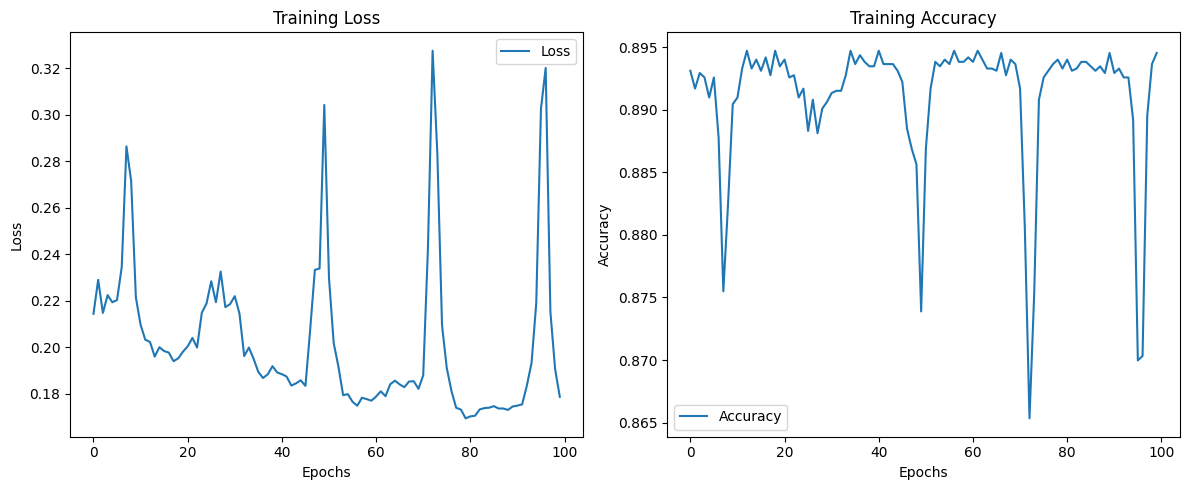

In [33]:
import matplotlib.pyplot as plt


# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# After model training
print(history.history.keys())  # Shows available metrics like 'loss', 'accuracy'

# Example: Print loss and accuracy for each epoch
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy']), 1):
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4%}")


dict_keys(['accuracy', 'loss'])
Epoch 1: Loss = 0.2144, Accuracy = 89.3124%
Epoch 2: Loss = 0.2290, Accuracy = 89.1699%
Epoch 3: Loss = 0.2148, Accuracy = 89.2946%
Epoch 4: Loss = 0.2225, Accuracy = 89.2590%
Epoch 5: Loss = 0.2194, Accuracy = 89.0987%
Epoch 6: Loss = 0.2204, Accuracy = 89.2590%
Epoch 7: Loss = 0.2345, Accuracy = 88.7781%
Epoch 8: Loss = 0.2864, Accuracy = 87.5490%
Epoch 9: Loss = 0.2715, Accuracy = 88.2437%
Epoch 10: Loss = 0.2215, Accuracy = 89.0452%
Epoch 11: Loss = 0.2097, Accuracy = 89.0987%
Epoch 12: Loss = 0.2033, Accuracy = 89.3302%
Epoch 13: Loss = 0.2024, Accuracy = 89.4727%
Epoch 14: Loss = 0.1960, Accuracy = 89.3302%
Epoch 15: Loss = 0.2001, Accuracy = 89.4015%
Epoch 16: Loss = 0.1984, Accuracy = 89.3124%
Epoch 17: Loss = 0.1978, Accuracy = 89.4193%
Epoch 18: Loss = 0.1941, Accuracy = 89.2768%
Epoch 19: Loss = 0.1953, Accuracy = 89.4727%
Epoch 20: Loss = 0.1982, Accuracy = 89.3481%
Epoch 21: Loss = 0.2004, Accuracy = 89.4015%
Epoch 22: Loss = 0.2041, Accurac

In [35]:
# Convert accuracy and loss to percentages
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy']), 1):
    print(f"Epoch {epoch}: Loss = {loss * 100:.2f}%, Accuracy = {acc * 100:.2f}%")


Epoch 1: Loss = 21.44%, Accuracy = 89.31%
Epoch 2: Loss = 22.90%, Accuracy = 89.17%
Epoch 3: Loss = 21.48%, Accuracy = 89.29%
Epoch 4: Loss = 22.25%, Accuracy = 89.26%
Epoch 5: Loss = 21.94%, Accuracy = 89.10%
Epoch 6: Loss = 22.04%, Accuracy = 89.26%
Epoch 7: Loss = 23.45%, Accuracy = 88.78%
Epoch 8: Loss = 28.64%, Accuracy = 87.55%
Epoch 9: Loss = 27.15%, Accuracy = 88.24%
Epoch 10: Loss = 22.15%, Accuracy = 89.05%
Epoch 11: Loss = 20.97%, Accuracy = 89.10%
Epoch 12: Loss = 20.33%, Accuracy = 89.33%
Epoch 13: Loss = 20.24%, Accuracy = 89.47%
Epoch 14: Loss = 19.60%, Accuracy = 89.33%
Epoch 15: Loss = 20.01%, Accuracy = 89.40%
Epoch 16: Loss = 19.84%, Accuracy = 89.31%
Epoch 17: Loss = 19.78%, Accuracy = 89.42%
Epoch 18: Loss = 19.41%, Accuracy = 89.28%
Epoch 19: Loss = 19.53%, Accuracy = 89.47%
Epoch 20: Loss = 19.82%, Accuracy = 89.35%
Epoch 21: Loss = 20.04%, Accuracy = 89.40%
Epoch 22: Loss = 20.41%, Accuracy = 89.26%
Epoch 23: Loss = 19.99%, Accuracy = 89.28%
Epoch 24: Loss = 21.

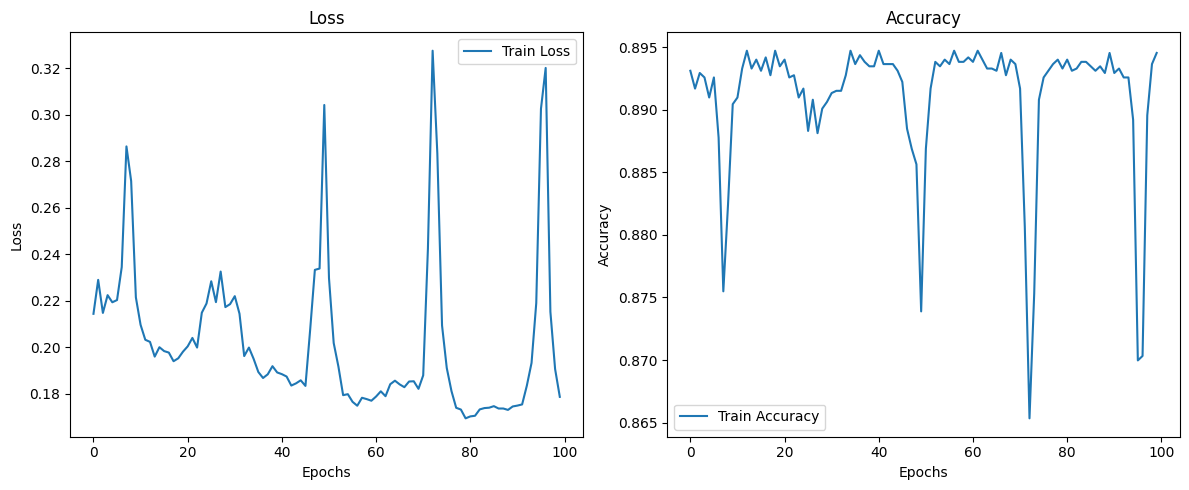

In [37]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
